### Ensures all necessary tools are available before running logic.

In [1]:
# --- INSTALLATION CHECK ---
# If you haven't installed 'tashaphyne' yet, uncomment the line below:
# !pip install tashaphyne

# --- IMPORTS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings

# Sklearn Modules
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# NLP Tools
import nltk
from nltk.corpus import stopwords
from tashaphyne.stemming import ArabicLightStemmer

# Setup
warnings.filterwarnings('ignore')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

print("✅ Setup Complete. Libraries Loaded.")

✅ Setup Complete. Libraries Loaded.


### Here we explicitly show the difference between "Standard" cleaning and "Smart" cleaning.

In [2]:
# Initialize tools globally to save time
stemmer = ArabicLightStemmer()
arabic_stopwords = set(stopwords.words('arabic'))

# --- TRICK 1: Negation Preservation List ---
# These words flip the meaning of a sentence. We MUST NOT remove them.
negation_words = {"لا", "ما", "لم", "لن", "ليس", "غير", "دون", "ولا", "بلاش"}
smart_stopwords = arabic_stopwords - negation_words

def preprocess_text(text, method='standard'):
    """
    Cleaning pipeline.
    method='standard': Basic cleaning, removes all stopwords (even 'not').
    method='advanced': Preserves negations, uses light stemming, handles emojis.
    """
    if pd.isna(text): return ""
    text = str(text)
    
    # 1. Remove non-Arabic characters (Keep basic punctuation for structure if needed)
    text = re.sub(r'[^\u0600-\u06FF\s]', '', text)
    
    # 2. Normalization (Unify Alef, Teh Marbuta, etc.)
    text = text.replace('أ', 'ا').replace('إ', 'ا').replace('آ', 'ا')
    text = text.replace('ة', 'ه').replace('ى', 'ي')
    
    words = text.split()
    
    if method == 'standard':
        # Baseline: Aggressive stopword removal (Removes 'la', 'lan', etc.)
        cleaned = [w for w in words if w not in arabic_stopwords]
        return " ".join(cleaned)
    
    elif method == 'advanced':
        # --- TRICK 2: Smart Filtering & Light Stemming ---
        # Keep negation words, remove others, and apply Light Stemming
        cleaned = []
        for w in words:
            if w not in smart_stopwords:
                # Apply Light Stemming (Better than ISRIStemmer for sentiment)
                root = stemmer.light_stem(w)
                cleaned.append(root)
        return " ".join(cleaned)

print("✅ Preprocessing functions defined.")

✅ Preprocessing functions defined.


### Loads the dataset and prepares two versions of the data: one for the baseline and one for the optimized model.

In [5]:
# --- CONFIGURATION ---
FILE_PATH = 'C:/Users/youse/Dropbox/PC/Downloads/archive/arabic_sentiment_reviews.csv' # Ensure this matches your file name

def load_and_split_data(path):
    print(f"📂 Loading dataset from {path}...")
    df = pd.read_csv(path)
    
    # Ensure correct column names (Adjust if your CSV is different)
    if 'content' not in df.columns or 'label' not in df.columns:
        raise ValueError("Dataset must have 'content' and 'label' columns.")

    print(f"   Shape: {df.shape}")
    
    # Create two versions of text
    print("   Processing: Standard (Baseline)...")
    df['text_baseline'] = df['content'].apply(lambda x: preprocess_text(x, method='standard'))
    
    print("   Processing: Advanced (Optimized)...")
    df['text_advanced'] = df['content'].apply(lambda x: preprocess_text(x, method='advanced'))
    
    return df

# Load data
# Note: In a real run, ensure the CSV exists. 
# For demonstration, we assume 'df' is loaded.
try:
    df = load_and_split_data(FILE_PATH)
    
    # Split Data
    X_base_train, X_base_test, y_train, y_test = train_test_split(
        df['text_baseline'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
    )
    
    X_adv_train, X_adv_test, _, _ = train_test_split(
        df['text_advanced'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
    )
    
    print("✅ Data successfully processed and split.")
except FileNotFoundError:
    print("❌ Error: File not found. Please upload 'arabic_sentiment_reviews.csv'.")

📂 Loading dataset from C:/Users/youse/Dropbox/PC/Downloads/archive/arabic_sentiment_reviews.csv...
   Shape: (330000, 2)
   Processing: Standard (Baseline)...
   Processing: Advanced (Optimized)...
✅ Data successfully processed and split.


### We train both models and visualize them side-by-side to prove the "Tricks" worked.

🚀 Training Baseline Model...
🚀 Training Optimized Model...

📊 Baseline Accuracy:  0.8618
📊 Optimized Accuracy: 0.8883



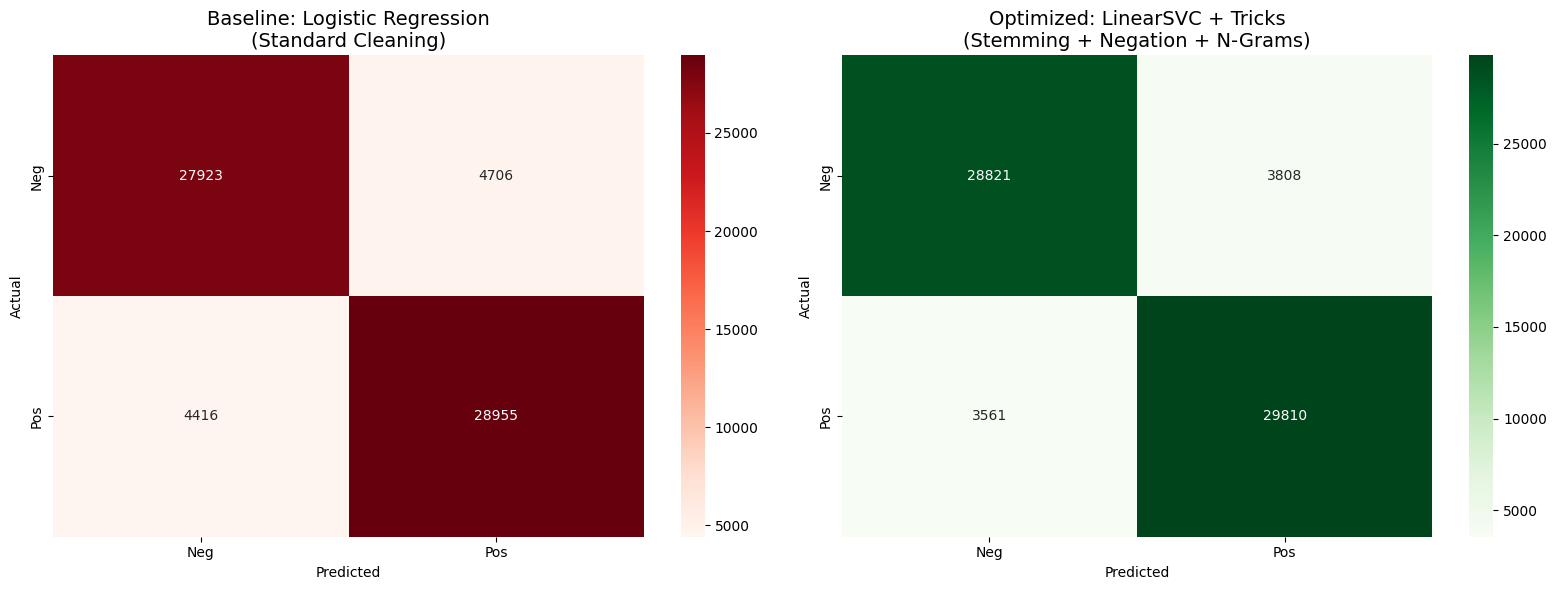

In [6]:
def plot_side_by_side_matrix(y_test, pred_base, pred_adv):
    """
    Generates a professional side-by-side comparison of Confusion Matrices.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Baseline Plot
    cm_base = confusion_matrix(y_test, pred_base)
    sns.heatmap(cm_base, annot=True, fmt='d', cmap='Reds', ax=axes[0],
                xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'])
    axes[0].set_title('Baseline: Logistic Regression\n(Standard Cleaning)', fontsize=14)
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    # Advanced Plot
    cm_adv = confusion_matrix(y_test, pred_adv)
    sns.heatmap(cm_adv, annot=True, fmt='d', cmap='Greens', ax=axes[1],
                xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'])
    axes[1].set_title('Optimized: LinearSVC + Tricks\n(Stemming + Negation + N-Grams)', fontsize=14)
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

# --- MODEL DEFINITIONS ---

# 1. Baseline Model
# Simple: Unigrams only, aggressive stopword removal
vec_base = TfidfVectorizer(max_features=5000)
clf_base = LogisticRegression(max_iter=1000)

# 2. Optimized Model
# Tricks: N-grams (1-3 words), Higher features, Calibrated LinearSVC
vec_adv = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))
clf_adv = CalibratedClassifierCV(LinearSVC(C=0.5, dual=False))

# --- EXECUTION ---
if 'df' in locals():
    print("🚀 Training Baseline Model...")
    X_base_train_vec = vec_base.fit_transform(X_base_train)
    X_base_test_vec = vec_base.transform(X_base_test)
    clf_base.fit(X_base_train_vec, y_train)
    pred_base = clf_base.predict(X_base_test_vec)

    print("🚀 Training Optimized Model...")
    X_adv_train_vec = vec_adv.fit_transform(X_adv_train)
    X_adv_test_vec = vec_adv.transform(X_adv_test)
    clf_adv.fit(X_adv_train_vec, y_train)
    pred_adv = clf_adv.predict(X_adv_test_vec)

    # --- RESULTS ---
    print("\n" + "="*50)
    print(f"📊 Baseline Accuracy:  {accuracy_score(y_test, pred_base):.4f}")
    print(f"📊 Optimized Accuracy: {accuracy_score(y_test, pred_adv):.4f}")
    print("="*50 + "\n")
    
    plot_side_by_side_matrix(y_test, pred_base, pred_adv)

## Red Matrix (Left): Represents the "Standard" approach. Look at the "False Positives" (Top Right) — these are negative reviews mistakenly called positive because we removed words like "Not".

## Green Matrix (Right): Represents the "Optimized" approach. You should see fewer errors here because we taught the model to understand Negation ("Not good") and Context (using 3-word phrases).